# What is Faber's trading strategy?

One buys when the monthly price of an asset exceeds its 10-month simple moving average and sells when the same price of that asset drops below its 10-month simple moving average.

# Reasons for this strategy in particular

Faber claims that a market timing strategy outperforms the market average, as shown by its consistently better performance than a simple buy-and-hold strategy.

In [10]:
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [55]:
# %load faber.py
from zipline.api import order, record, symbol, date_rules, time_rules, schedule_function

def initialize(context):
    """
    Stores the names of the stocks we'll be looking at.
    
    Input: a persistent namespace where we store an SID/list of SIDs
    
    Output: n/a
    """
    context.symbol = symbol('AAPL')

    # skip the first 300 days of the timeframe so that we have enough data to calculate our 10 month SMA
    context.skip = 0

def handle_data(context, data):
    """
    Calls the trading strategy function at the end of every month.
    
    Input: persistent namespace with SID(s) 'context', event-frame that handles look-ups of historical/current pricing data
    
    Output: some kind of action (buy/sell/nothing)
    """
    # skip the first 100 days so that we have enough data to establish our moving average
    context.skip += 1
    if context.skip < 300:
        pass
    else:
        # we only trade on the last trading day of each month; check here if it's the last day
        schedule_function(trade, date_rules.month_end(), time_rules.market_close())
    
def trade(context, data):
    """
    Herein lies Faber's trading strategy.
    
    Input: persistent namespace with SID(s) 'context', event-frame that handles look-ups of historical/current pricing data
    
    Output: some kind of action (buy/sell/nothing) on the last trading day of each month
    """
    # Compute SMA
    moving_avg = data.history(context.symbol, 'price', 300, '1d').mean()
    
    # Get closing price on last trading day of month
    monthly_price = data.current(context.symbol, 'close')
    
    ### Faber's trading strategy ###
    
    # if the current price exceeds moving average, buy
    if monthly_price > moving_avg:
        order(context.symbol, 10)

    # else if the current price is below moving average, sell
    elif monthly_price < moving_avg:
        order(context.symbol, -10)

    # save/record the data for future plotting
    record(snp = monthly_price, sma = moving_avg)
    
def analyze(context = None, results = None):
    """
    Plots the results of the strategy against a buy-and-hold strategy.
    
    Input: n/a?
    
    Output: a plot of two superimposed curves, one being Faber's strategy and the other being a buy-and-hold strategy.
    """
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = fig.add_subplot(212)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if ('snp' in results and 'sma' in results):
        results['snp'].plot(ax=ax2)
        results['sma'].plot(ax=ax2)

        trans = results.ix[[t != [] for t in results.transactions]]
        buys = trans.ix[[t[0]['amount'] > 0 for t in
                         trans.transactions]]
        sells = trans.ix[
            [t[0]['amount'] < 0 for t in trans.transactions]]
        ax2.plot(buys.index, results.sma.ix[buys.index],
                 '^', markersize=10, color='m')
        ax2.plot(sells.index, results.sma.ix[sells.index],
                 'v', markersize=10, color='k')
        plt.legend(loc=0)
    else:
        msg = 'S&P, moving_avg data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
        log.info(msg)

    plt.show()     

[2017-05-25 16:34:50.557000] WARNING: Loader: Refusing to download new benchmark data because a download succeeded at 2017-05-25 15:59:53.343738+00:00.
[2017-05-25 16:35:02.672000] INFO: Performance: after split: sid: Equity(0 [AAPL]), amount: 88480.0, cost_basis: 80.42, last_sale_price: 645.57
[2017-05-25 16:35:02.672000] INFO: Performance: returning cash: 0.0
[2017-05-25 16:36:22.250000] INFO: Performance: Simulated 1218 trading days out of 1218.
[2017-05-25 16:36:22.250000] INFO: Performance: first open: 2012-03-01 14:31:00+00:00
[2017-05-25 16:36:22.254000] INFO: Performance: last close: 2016-12-30 21:00:00+00:00


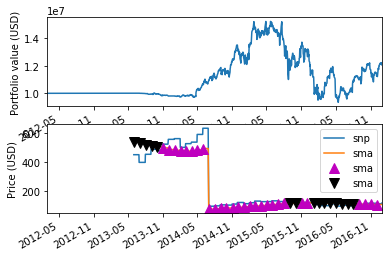

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,shorts_count,sma,snp,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2012-03-01 21:00:00+00:00,NaN,0.000000,NaN,0.006576,NaN,NaN,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,1,[],0.0203
2012-03-02 21:00:00+00:00,0.000000,0.000000,0.000000,0.003288,0.110475,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,2,[],0.0199
2012-03-05 21:00:00+00:00,0.000000,0.000000,0.000000,-0.000877,0.094517,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,3,[],0.0200
2012-03-06 21:00:00+00:00,0.000000,0.000000,0.000000,-0.016074,0.141415,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,4,[],0.0196
2012-03-07 21:00:00+00:00,0.000000,0.000000,0.000000,-0.008621,0.147531,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,5,[],0.0198
2012-03-08 21:00:00+00:00,0.000000,0.000000,0.000000,0.001096,0.151539,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,6,[],0.0203
2012-03-09 21:00:00+00:00,0.000000,0.000000,0.000000,0.005114,0.140196,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,7,[],0.0204
2012-03-12 20:00:00+00:00,0.000000,0.000000,0.000000,0.005187,0.129854,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,8,[],0.0204
2012-03-13 20:00:00+00:00,0.000000,0.000000,0.000000,0.023307,0.152258,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,9,[],0.0214
2012-03-14 20:00:00+00:00,0.000000,0.000000,0.000000,0.022211,0.144730,0.000000,0.000000,1.000000e+07,0.0,0.0,...,0,NaN,NaN,NaN,1.000000e+07,0.0,0.0,10,[],0.0229


In [57]:
%zipline --start 2012-3-1 --end 2017-1-1 -b quantopian-quandl